In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

[*********************100%***********************]  1 of 1 completed


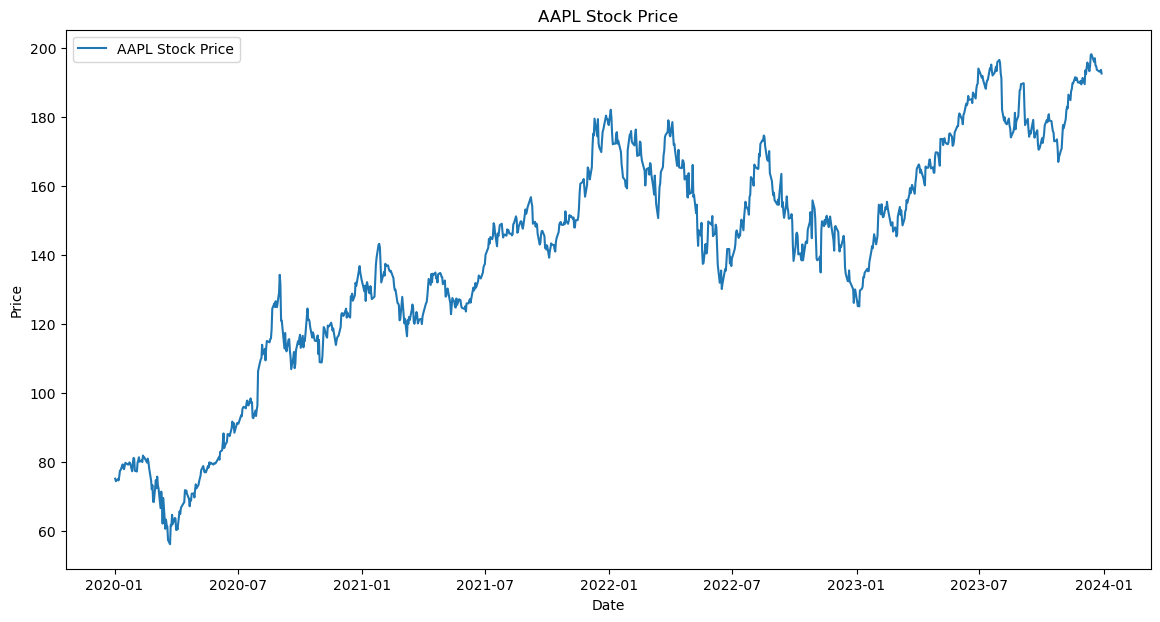

In [2]:
# Define stock ticker and time period
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

# Fetch stock data from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date)

# Plot the stock data
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label=f'{ticker} Stock Price')
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
# Use only the 'Close' price
data = df[['Close']].values

# Normalize the data to improve LSTM training performance
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define train-test split
train_size = int(len(data) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

# Create training and testing datasets
def create_lstm_data(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Number of previous days to look back

X_train, Y_train = create_lstm_data(train_data, time_step)
X_test, Y_test = create_lstm_data(test_data, time_step)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Predict stock prices using LSTM
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scale the predictions
train_predictions = scaler.inverse_transform(np.reshape(train_predictions, (-1, 1)))
Y_train_inv = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))

test_predictions = scaler.inverse_transform(np.reshape(test_predictions, (-1, 1)))
Y_test_inv = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))

Epoch 1/10
24/24 [==============================] - 6s 60ms/step - loss: 0.0831
Epoch 2/10
24/24 [==============================] - 1s 59ms/step - loss: 0.0045
Epoch 3/10
24/24 [==============================] - 1s 60ms/step - loss: 0.0027
Epoch 4/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0021
Epoch 5/10
24/24 [==============================] - 1s 59ms/step - loss: 0.0019
Epoch 6/10
24/24 [==============================] - 1s 60ms/step - loss: 0.0018
Epoch 7/10
24/24 [==============================] - 1s 62ms/step - loss: 0.0018
Epoch 8/10
24/24 [==============================] - 1s 60ms/step - loss: 0.0018
Epoch 9/10
24/24 [==============================] - 1s 59ms/step - loss: 0.0018
Epoch 10/10
5/5 [==============================] - 0s 20ms/step


In [6]:
# Calculate RMSE, MAE, R^2 for LSTM
lstm_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predictions))
lstm_mae = mean_absolute_error(Y_test_inv, test_predictions)
lstm_r2 = r2_score(Y_test_inv, test_predictions)

print(f"LSTM Model RMSE: {lstm_rmse}")
print(f"LSTM Model MAE: {lstm_mae}")
print(f"LSTM Model R²: {lstm_r2}")

LSTM Model RMSE: 7.343197214642196
LSTM Model MAE: 6.393857606699767
LSTM Model R²: 0.17846530554839835


In [7]:
# Fit the ARIMA model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['Close'][:train_size], order=arima_order)
arima_fit = arima_model.fit()

# Forecast on test data
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Compare LSTM and ARIMA predictions
arima_forecast_inv = arima_forecast

# Calculate RMSE, MAE, R² for ARIMA
arima_rmse = np.sqrt(mean_squared_error(df['Close'][train_size:], arima_forecast_inv))
arima_mae = mean_absolute_error(df['Close'][train_size:], arima_forecast_inv)
arima_r2 = r2_score(df['Close'][train_size:], arima_forecast_inv)

print(f"ARIMA Model RMSE: {arima_rmse}")
print(f"ARIMA Model MAE: {arima_mae}")
print(f"ARIMA Model R²: {arima_r2}")

ARIMA Model RMSE: 30.9695423157427
ARIMA Model MAE: 28.963291357473068
ARIMA Model R²: -6.97993488666148


C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

In [8]:
print("Model Comparison:")
print("--------------------------------")
print(f"**LSTM Model RMSE:** {lstm_rmse}")
print(f"**LSTM Model R²:** {lstm_r2}")
print(f"**ARIMA Model RMSE:** {arima_rmse}")
print(f"**ARIMA Model R²:** {arima_r2}")

Model Comparison:
--------------------------------
**LSTM Model RMSE:** 7.343197214642196
**LSTM Model R²:** 0.17846530554839835
**ARIMA Model RMSE:** 30.9695423157427
**ARIMA Model R²:** -6.97993488666148
